# Kombergend volume door overlopen

versie met probabilistic library van deltares, zie [deze link](https://github.com/Deltares/ProbabilisticLibrary)

Omgevingswet:
Artikel 2.0c Besluit kwaliteit leefomgeving
https://wetten.overheid.nl/jci1.3:c:BWBR0041313&hoofdstuk=2&afdeling=2.1&paragraaf=2.1.1&artikel=2.0c&z=2024-12-21&g=2024-12-21

Voor dijktrajecten als bedoeld in bijlage II, onder A, geldt de ten hoogste toelaatbare kans per jaar op verlies van waterkerend vermogen waardoor het door het dijktraject beschermde gebied overstroomt op een zodanige wijze en in zodanige mate dat dit leidt tot dodelijke slachtoffers of substantiële economische schade, bedoeld in bijlage II, onder B, kolom 1.

In de Grondslagen Waterkeringen wordt een praktisch criterium beschreven voor het begrip substantiële economische schade:
"als de gemiddelde Waterdiepte in minimaal één gebied of buurt met gelijke viercijferige postcode (op basis van de wijk- en buurtkaart van het CBS) groter is dan 0,2 meter, is er sprake van een overstroming. Dit criterium is gebaseerd op de ervaring dat slachtoffers en grootschalige schade pas optreden als de lokale water­dieptes groter zijn dan circa 0,2 meter. Van dit algemene principe kan in specifieke situaties onderbouwd worden afgeweken."


## Grenstoestandfuncties

Uitgaande van de hierboven genoemde definitie voor substantiële schade, treedt falen op als het volume water dat tijdens een hoogwaterevent over de dijk stroomt ($V_{overlopen}$) groter is dan het volume water voordat substantiële schade optreedt ($V_{komberging}$). In deze situatie is het waarschijnlijk dat er sprake is van overlopen, dat wil zeggen dat de lokale waterstand groter is dan de kruinhoogte. De grenstoestandfunctie wordt als volgt gedefinieerd:

$$Z = V_{komberging} - V_{overlopen}$$

We beschouwen het volume per strekkende meter waterkering [m³/m]. Met deze aanpak sluiten we aan op de grenstoestandfunctie van het eroderen van de toplaag. Gebruikelijk is het om de lengte van de dijkvakken aan te laten sluiten bij de onderlinge afstand van de uitvoerlocaties.
De formule voor het overstromend debiet per strekkende meter waterkering is:

$$q = 0.6 \sqrt{g \Delta h^3}$$

met:

* $q$: overlopend debiet per strekkende meter waterkering [m²/s]
* $g$: zwaartekrachtversnelling [m/s²]
* $\Delta h$: hoogteverschil tussen de lokale waterstand en de kruin (positief) [m]

Het volume water dat over de kering stroomt is afhankelijk van het hoogteverschil als functie van tijd $\Delta h(t)$ en de duur dat het water over de kering stroomt. Het waterstandsverloop is trapeziumvormig aangenomen met een gelijke stijg- en daalsnelheid $s$ en duur van de top $t_{top}$. De duur $t_{overlopen}$ dat het water over de kering stroomt is daarmee een functie van $\Delta h$. Door substitutie en integratie over de tijdsduur van overlopend water wordt het volume berekend.

$$V_{overlopen} = \int_{t = 0}^{t_{overlopen}} q(t)\,dt\$$

## Stochasten

De volgende stochasten zijn relevant

* $V_{komberging}$: het volume per strekkende meter waterkering dat net geborgen kan worden voordat sprake is van substantiële economische schade [m³/m]
* $h$: buitenwaterstand [m+NAP]
* $\Delta h_{kruin}$: de onzekerheid in de kruinhoogte over ca. 100 m
* $s$: stijgsnelheid van het water [m/uur]
* $t_{top}$: duur van de top van de waterstand [uur]

Daarnaast is de variabele $h_kruin$ van belang. Dit is veelal de minimale maximale kruinhoogte van het vak. Deze waarde wordt ook gebruikt in de beoordeling om de zwakste plek in het vak te schematiseren.

In het geval van overlopen over een waterkering neemt het overstroomde debiet sterk toe bij een stijgende buitenwaterstand. Hierdoor kan het lastig zijn om convergentie te bereiken in een probabilistische berekening. Een alternatieve methode is om de conditionele kans uit te rekenen gegeven een waterstandsverschil over de kruinhoogte. Deze methode wordt uitgewerkt in deze notebook.



In [1]:
# import van benodigde bibliotheken
from probabilistic_library import (
    ReliabilityProject,
    DistributionType,
    CompareType,
    ReliabilityMethod,
    FragilityCurve,
    FragilityValue,
    Stochast,
)
import numpy as np
import matplotlib.pyplot as plt




## Functies

We definiëren de functies voor het overloop debiet, het waterstandsverloop en het instromend volume.

### Overlopend debiet

In [2]:
# function: overstromend debiet

import math

def overstromend_debiet(g: float,dh: float) -> float:
    """
    Bereken het overstromend debiet per strekkende meter dijk in m3/s/m.

    Parameters:
    g (float): Gravitatieversnelling in m/s^2 (standaardwaarde is 9.81 m/s^2).
    dh (float): Hoogteverschil tussen de waterstand en kruinhoogte.

    Returns:
    float: Overstromend debiet per strekkende meter in m3/s/m.
    """
    if dh <= 0:
        q = 0.0
    else:
        q = 0.6 * math.sqrt(g * math.pow(dh, 3)) #formule voor overstromend debiet
    return q

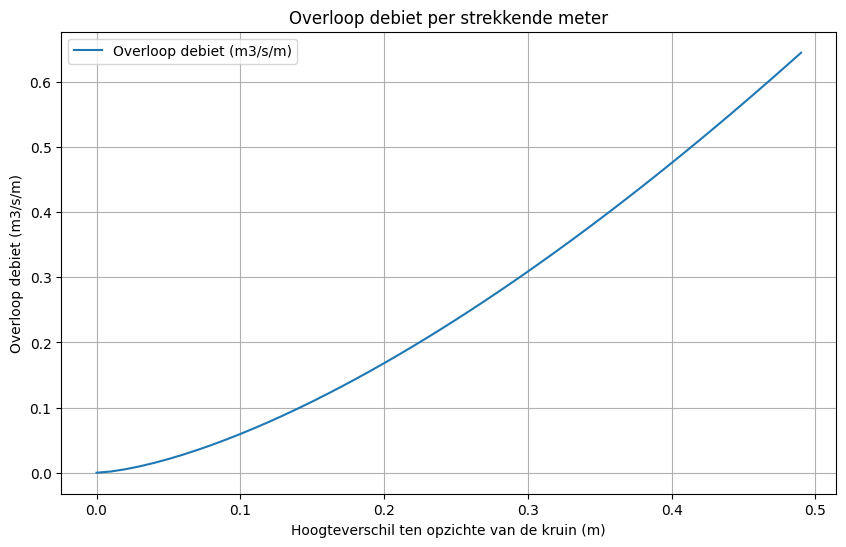

In [3]:
dh_plot = np.arange(0.00,0.5,0.01) # Hoogteverschil van 0.00 m tot 0.5 m
debiet_plot = [overstromend_debiet(9.81, dh) for dh in dh_plot]

# Plotten van het overstromend debiet als functie van het hoogteverschil
plt.figure(figsize=(10, 6))
plt.plot(dh_plot, debiet_plot, label='Overloop debiet (m3/s/m)')
plt.title('Overloop debiet per strekkende meter')
plt.xlabel('Hoogteverschil ten opzichte van de kruin (m)')
plt.ylabel('Overloop debiet (m3/s/m)')
plt.grid()
plt.legend()
plt.show()

### Waterstandsverloop

Het waterstandsverloop wordt geschematiseerd als een trapezium op basis van de variabelen stijgsnelheid $s$, maximale waterstand boven de kruin $\Delta h_{max}$ en tijdsduur van de top.

In [4]:
# sterkte v_komberging
# v_komberging = 5000.0 * 0.2 # m3/m
# onzekerheid kruinhoogte
# dh_kruin = 0.1 # m
# kruinhoogte
# h_kruin = 4.9 # m

# tijdsverloop definiëren
stijgsnelheid = 0.04/3600 # m/s
tijdsduur_van_de_top = 2.0* 3600 # seconden
dh_max = 0.10 # m

In [5]:
def trapezium_dh(
    dh_max: float, stijgsnelheid: float, tijdsduur_top: float, dt: float = 1.0
):
    """
    Genereer een trapeziumvormige tijdreeks voor dh.

    Parameters:
    dh_max (float): Maximale waarde van dh.
    stijgsnelheid (float): Stijgsnelheid van de op- en aflopende flank (m/s).
    breedte_top (float): Duur van het plateau (seconden).
    dt (float): Tijdstap (seconden).

    Returns:
    tuple: (times, dh) arrays
    """
    # Bepaal de tijdsduur van de op- en aflopende flank
    t_flank = dh_max / stijgsnelheid  # tijd voor op- en aflopen
    t_total = 2 * t_flank + tijdsduur_top  # totale tijdsduur

    # Tijd-array
    times = np.arange(0, t_total + dt, dt)

    # dh-array opbouwen
    dh = np.zeros_like(times)
    for i, t in enumerate(times):
        if t < t_flank:
            dh[i] = stijgsnelheid * t
        elif t < t_flank + tijdsduur_top:
            dh[i] = dh_max
        elif t <= t_total:
            dh[i] = dh_max - stijgsnelheid * (t - t_flank - tijdsduur_top)
        else:
            dh[i] = 0.0
    dh = np.clip(dh, 0, dh_max)
    return times, dh


# Voorbeeld aanroep:
times, dh = trapezium_dh(0.10, stijgsnelheid, tijdsduur_van_de_top, dt=10.0)


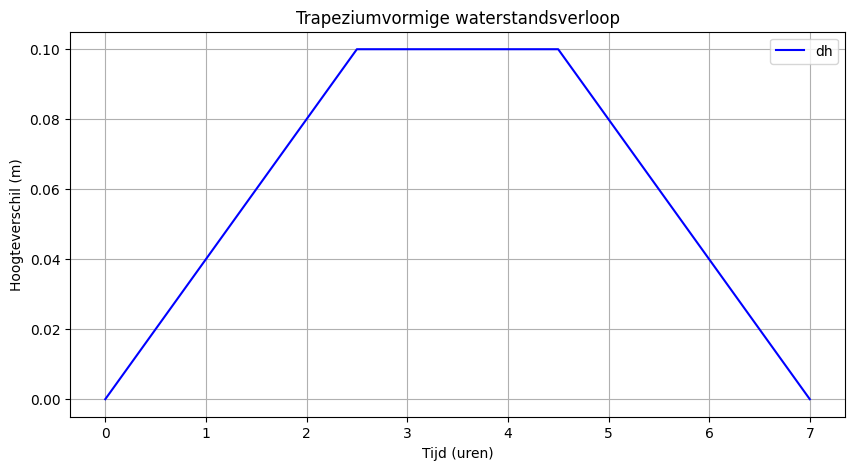

In [6]:


def plot_dh(times, dh):
    """
    Plot de dh-waarden over de tijd.

    Parameters:
    times (array): Tijdstappen.
    dh (array): Hoogteverschillen.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(times / 3600, dh, label='dh', color='blue')
    plt.xlabel('Tijd (uren)')
    plt.ylabel('Hoogteverschil (m)')
    plt.title('Trapeziumvormige waterstandsverloop')
    plt.grid()
    plt.legend()
    plt.show()

# Plot de trapeziumvormige tijdreeks
plot_dh(times, dh)

### Instromend volume

Door het overloop debiet te integreren over het waterstandsverloop wordt het totale overlopend volume tijdens een hoogwaterevent berekend.

In [7]:
def totaal_volume(times, dh, g=9.81):
    """
    Bereken het totale volume water dat over de dijk stroomt, gegeven een waterstandverloop.

    Parameters:
    times (array): Tijdreeks (seconden).
    dh (array): Hoogteverschillen (m).
    g (float): Gravitatieversnelling (m/s^2).

    Returns:
    float: Totaal volume (m3 per strekkende meter dijk).
    """
    # Bereken het debiet voor elk tijdstip
    q = np.array([overstromend_debiet(g, h) for h in dh])
    # Integreer debiet over de tijd (trapeziumregel)
    volume = np.trapezoid(q, times)
    return volume

# Voorbeeld aanroep:
volume = totaal_volume(times, dh)
print(f"Totaal volume: {volume:.2f} m3/m")

Totaal volume: 855.75 m3/m


In [8]:
def volume_trapezium_overloop(
    dh_max: float, stijgsnelheid: float, breedte_top: float, dt: float = 1.0, g: float = 9.81
) -> float:
    """
    Combineer het genereren van een trapeziumvormige dh-tijdreeks en het berekenen van het totale volume.

    Parameters:
    dh_max (float): Maximale waarde van dh.
    stijgsnelheid (float): Stijgsnelheid van de op- en aflopende flank (m/s).
    breedte_top (float): Duur van het plateau (seconden).
    dt (float): Tijdstap (seconden).
    g (float): Gravitatieversnelling (m/s^2).

    Returns:
    float: Totaal volume (m3 per strekkende meter dijk).
    """
    # Genereer tijdreeks en dh
    times, dh = trapezium_dh(dh_max, stijgsnelheid, breedte_top, dt)
    # Bereken volume
    q = np.array([overstromend_debiet(g, h) for h in dh])
    volume = np.trapezoid(q, times)
    return float(volume)

# Voorbeeld aanroep:
volume2 = volume_trapezium_overloop(0.11, 0.04/3600, 2.0*3600, dt=10.0)
print(f"Totaal volume: {volume:.2f} m3/m")

Totaal volume: 855.75 m3/m


## Model grenstoestandfunctie komberging

De volgende grenstoestandfunctie wordt gedefinieerd:

In [9]:
def z_komberging(
    v_kom: float,
    stijgsnelheid: float,
    breedte_top: float,
    dh_max: float,
) -> float:
    # berekening instromend volume
    volume_in = volume_trapezium_overloop(dh_max, stijgsnelheid, breedte_top, dt=10.0)
    # grenstoestandfunctie
    z = v_kom - volume_in
    return z


# def z_komberging(X):
#     v_kom, dh_max, stijgsnelheid, breedte_top = X
#     #berekening instromend volume
#     volume_in = volume_trapezium_overloop(dh_max, stijgsnelheid, breedte_top, dt=10.0)
#     #grenstoestandfunctie
#     z = v_kom - volume_in
#     return [z]

# limit_state_function = ot.PythonFunction(4, 1, z_komberging)

# #evaluate function at a point
# X = [5000.0 * 0.2, 0.15, 0.10/3600, 1.0*3600]

print(f"Z-waarde: {z_komberging(5000.0 * 0.2, 0.10/3600, 1.0*3600, 0.15):.2f} m3/m")

Z-waarde: 135.33 m3/m


## Model en invoer

De volgende variabelen worden gedefinieerd:

In [10]:
project = ReliabilityProject()
project.model = z_komberging

project.variables["v_kom"].distribution = DistributionType.log_normal
project.variables["v_kom"].mean = 5000.0 * 0.2 # m3/m
project.variables["v_kom"].deviation = 5000.0 * 0.2 * 0.05  # m3/m

project.variables["stijgsnelheid"].distribution = DistributionType.log_normal
project.variables["stijgsnelheid"].mean = 0.05/3600 # m/s
project.variables["stijgsnelheid"].deviation = 0.08/3600 * 0.2 # m/s

project.variables["breedte_top"].distribution = DistributionType.log_normal
project.variables["breedte_top"].mean = 2.0*3600 # seconden
project.variables["breedte_top"].deviation = 2.0*3600 * 0.2 # seconden


Plotten van de verdelingen:

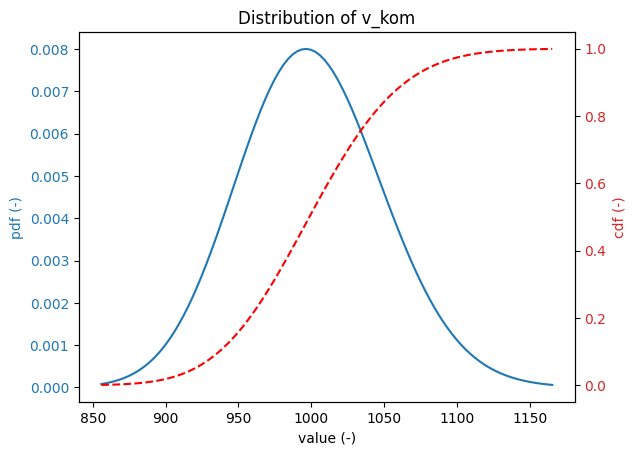

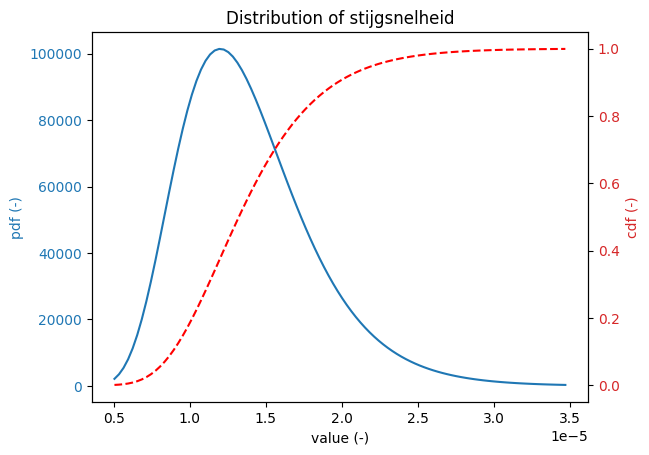

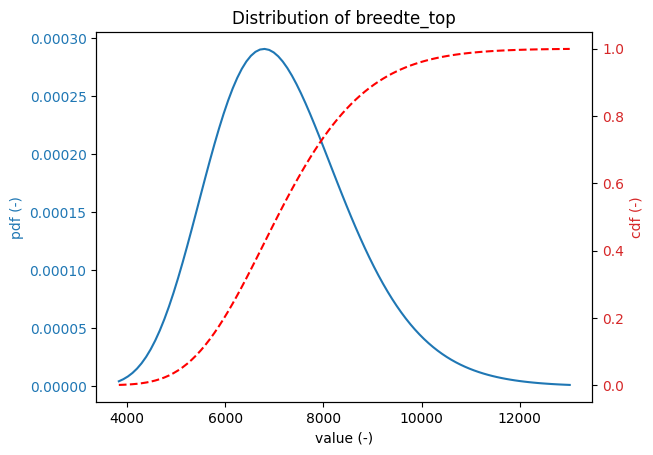

In [11]:
def plot_dist(val_grid, stochast):

    pdf = [stochast.get_pdf(val) for val in val_grid]
    cdf = [stochast.get_cdf(val) for val in val_grid]

    fig, ax1 = plt.subplots()
    color = "tab:blue"
    ax1.set_xlabel("value (-)")
    ax1.set_ylabel("pdf (-)", color=color)
    ax1.plot(val_grid, pdf)
    ax1.tick_params(axis="y", labelcolor=color)
    ax2 = ax1.twinx()
    color = "tab:red"
    ax2.set_ylabel("cdf (-)", color=color)
    ax2.plot(val_grid, cdf, "r--", label="pdf")
    ax2.tick_params(axis="y", labelcolor=color)
    plt.title(f"Distribution of {stochast.name}")

for var in ["v_kom", "stijgsnelheid", "breedte_top"]:
    stochast = Stochast()
    stochast.name = var
    stochast.distribution = project.variables[var].distribution
    stochast.mean = project.variables[var].mean
    stochast.deviation = project.variables[var].deviation
    val_grid = np.linspace(
        stochast.get_quantile(0.001), stochast.get_quantile(0.999), 100
    )
    plot_dist(val_grid, stochast)

We kiezen `FORM` als ReliabilityMethod

In [12]:
project.settings.reliability_method = ReliabilityMethod.form

project.settings.relaxation_factor = 0.15
project.settings.maximum_iterations = 50
project.settings.variation_coefficient = 0.02

## Fragility curve maken



In [13]:
def print_results(dp):
        print(f"reliability index = {dp.reliability_index}")
        print(f"Pf = {dp.probability_failure}")

        for alpha in dp.alphas:
                print(f"{alpha.variable.name}: alpha = {alpha.alpha}, x = {alpha.x}")



In [14]:
fragility_curve = FragilityCurve()
fragility_curve.name = "Conditioneel op dh_max"

fc_pf = []
dh_max = np.arange(0.00,0.3,0.01) # Hoogteverschil van 0.00 m tot 0.3 m
for dh in dh_max:
    project.variables["dh_max"].distribution = DistributionType.deterministic
    project.variables["dh_max"].mean = dh
    project.run()
    dp = project.design_point
    print(f"dh = {dh}, converged = {dp.is_converged}")
    print_results(dp)
    print("--------------------------------------------------")

    value = FragilityValue()
    value.x = dh
    value.reliability_index = dp.reliability_index
    value.design_point = dp

    fragility_curve.fragility_values.append(value)
    fc_pf.append(dp.probability_failure)

    

dh = 0.0, converged = False
reliability index = 40.87204840745492
Pf = 0.0
v_kom: alpha = 1.0, x = 129.56464468141408
stijgsnelheid: alpha = -0.0, x = 1.322811315554615e-05
breedte_top: alpha = -0.0, x = 7060.1808649746245
dh_max: alpha = 0.0, x = 0.0
--------------------------------------------------
dh = 0.01, converged = False
reliability index = 40.3369398071338
Pf = 0.0
v_kom: alpha = 0.982028650123756, x = 137.98452123692806
stijgsnelheid: alpha = 0.016752500810282775, x = 1.0711890552228011e-05
breedte_top: alpha = -0.18798692521746155, x = 31695.936624257243
dh_max: alpha = 0.0, x = 0.01
--------------------------------------------------
dh = 0.02, converged = True
reliability index = 16.025794630603162
Pf = 4.220248484249698e-58
v_kom: alpha = 0.2444249673437463, x = 821.20589730617
stijgsnelheid: alpha = 0.012528636222825023, x = 1.2424293751774555e-05
breedte_top: alpha = -0.9695872671469055, x = 153197.94878277645
dh_max: alpha = 0.0, x = 0.02
------------------------------

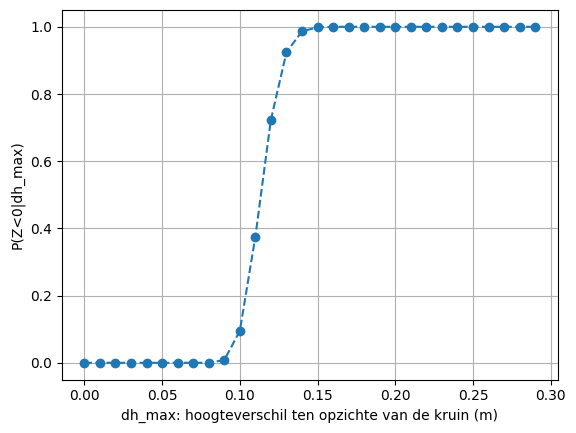

In [15]:
plt.plot(dh_max, fc_pf, 'o--')
plt.grid()
plt.xlabel('dh_max: hoogteverschil ten opzichte van de kruin (m)')
plt.ylabel('P(Z<0|dh_max)')
plt.show()